# Import and load data

In [255]:
import pandas as pd
import sqlite3

In [256]:
df_crime = pd.read_csv('calgary_crime_stats.csv')

In [257]:
conn = sqlite3.connect('../database.db')

df_listings = pd.read_sql_query("SELECT * FROM rental_listings ", conn)
conn.close()

# Looking at the data

In [258]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81875 entries, 0 to 81874
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sector                  81691 non-null  object 
 1   Community Name          81875 non-null  object 
 2   Category                81875 non-null  object 
 3   Crime Count             81874 non-null  float64
 4   Date                    81875 non-null  object 
 5   Year                    81875 non-null  int64  
 6   Month                   81875 non-null  object 
 7   ID                      81875 non-null  object 
 8   Resident Count          2488 non-null   float64
 9   Community Center Point  81691 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 6.2+ MB


In [259]:
df_crime.head(3)

,Sector,Community Name,Category,Crime Count,Date,Year,Month,ID,Resident Count,Community Center Point
0,NORTH,03W,Theft FROM Vehicle,1.0,2022/04,2022,APR,2022-APR-03W-Theft FROM Vehicle,NaN,POINT (-114.026242634091 51.197967711165)
1,NORTHEAST,05D,Theft FROM Vehicle,1.0,2022/04,2022,APR,2022-APR-05D-Theft FROM Vehicle,NaN,POINT (-113.958660846149 51.179594126023)
2,EAST,09O,Theft OF Vehicle,2.0,2022/04,2022,APR,2022-APR-09O-Theft OF Vehicle,NaN,POINT (-113.877106941343 51.052571080807)


## (a) Simple cleaning (lowercase and strip)

In [260]:
df_crime['Community Name_cleaned']=df_crime['Community Name'].str.lower().str.strip()

In [261]:
df_listings['community_cleaned'] = df_listings['community'].str.lower().str.strip()

In [262]:
df_listings['is_in'] = df_listings['community_cleaned'].apply(lambda x: any(x in name for name in df_crime['Community Name_cleaned']))


In [263]:
df_listings['is_in'].value_counts(normalize=True)

is_in
True     0.942318
False    0.057682
Name: proportion, dtype: float64

Not bad, 94.2% of the communities matched, 5.8% unmatched.

In [264]:
unmatched_listings = df_listings[df_listings['is_in'] == False].copy()
unmatched_listings['community_cleaned'].sort_values().unique()

array(['academy', 'bearspaw', 'belaire', 'connaught', 'creekstone',
       'douglas glen', 'dover glen', 'evergreen estates', 'fonda',
       'greenwich', 'hanson ranch', 'heritage pointe', 'kensington',
       'lynnwood', 'marda loop', 'mountview parc',
       'parkhill-stanley park', 'patterson heights', 'pumphill',
       'quarry park', 'richmond/knob hill', 'rockland park',
       'saddlebrook', 'savanna', 'silverton', 'sirocco',
       'st andrews heights', 'stanley park', 'trinity hills', 'triwood',
       'vermillon hill', 'victoria park', 'west dover', 'westbrook',
       'westmount'], dtype=object)

In [265]:
unmatched_listings.shape

(556, 36)

In [266]:
matched_names = df_listings[df_listings['is_in'] == True]['community_cleaned'].unique()

# Get the unmatched names
unmatched_in_crime = df_crime[~df_crime['Community Name_cleaned'].isin(matched_names)]['Community Name_cleaned'].unique()


In [267]:
unmatched_in_crime

array(['03w', '05d', '09o', '12a', '12j', 'albert park/radisson heights',
       'alyth/bonnybrook', 'applewood park', 'beddington heights',
       'bridgeland/riverside', 'burns industrial',
       'calgary international airport', 'chinatown', 'christie park',
       '05c', 'deerfoot business centre', 'douglasdale/glen',
       'downtown commercial core', 'downtown east village',
       'downtown west end', 'eagle ridge', 'east fairview industrial',
       'east shepard industrial', '03i', 'eastfield',
       'fairview industrial', 'fish creek park', 'foothills',
       'forest lawn industrial', 'franklin', 'glendeer business park',
       'glenmore park', 'golden triangle', 'great plains',
       'greenview industrial park', 'greenwood/greenbriar', 'highfield',
       'horizon', 'hounsfield heights/briar hill', 'killarney/glengarry',
       'manchester industrial', 'mayland', 'mccall', 'meridian',
       'north airways', 'nose hill park', 'ogden shops', 'parkhill',
       'pegasus', 

## (b) Matching with Fuzzy Matching

In [268]:
from thefuzz import process

# Get a list of unique community names from df_crime
names_array = df_crime['Community Name_cleaned'].unique()

def fuzzy_match(name):
    
    #print(f'fuzzy matching {name}')
    best_match = process.extractOne(name, names_array) #score_cutoff=90
    return best_match[0]  if best_match[1] >= 90 else 'Unmatched'


unmatched_listings['community_cleaned_fuzz_one'] = unmatched_listings['community_cleaned'].apply(fuzzy_match)

In [269]:
unmatched_listings['community_cleaned_fuzz_one'].value_counts()

community_cleaned_fuzz_one
Unmatched              451
richmond                61
parkhill                18
evergreen                8
st. andrews heights      7
pump hill                5
dover                    3
bel-aire                 2
patterson                1
Name: count, dtype: int64

Remove those unmatched in fuzz one, only show unique combinations.

Known correct matches:

richmond/knob hill -> richmond
pumphill -> pump hill
st andrews heights -> st. andrews heights
west dover	-> dover
evergreen estates -> evergreen
belaire -> bel-aire
douglas glen -> douglasdale/glen
parkhill-stanley park -> parkhill
mountview parc -> winston heights/mountview
patterson heights -> patterson
dover glen -> dover


In [270]:
unmatched_listings[unmatched_listings['community_cleaned_fuzz_one'] != 'Unmatched'][['community_cleaned','community_cleaned_fuzz_one']].drop_duplicates()

,community_cleaned,community_cleaned_fuzz_one
162,richmond/knob hill,richmond
182,pumphill,pump hill
396,st andrews heights,st. andrews heights
532,west dover,dover
1241,evergreen estates,evergreen
1515,belaire,bel-aire
1560,parkhill-stanley park,parkhill
6779,patterson heights,patterson
8345,dover glen,dover


After testing with different cut-off thresholds, the matching result with cutoff score 90 is satisfactory.

In [271]:

df_listings['community_cleaned_fuzz_one'] = df_listings['community_cleaned'].apply(fuzzy_match)

In [272]:
matched_results = df_listings[df_listings['community_cleaned_fuzz_one'] != 'Unmatched'][['community_cleaned','community_cleaned_fuzz_one']].drop_duplicates()

In [432]:
df_listings['community_cleaned_fuzz_one'].value_counts()

community_cleaned_fuzz_one
Unmatched                   451
beltline                    427
downtown commercial core    277
seton                       264
livingston                  253
                           ... 
maple ridge                   4
valley ridge                  3
bel-aire                      2
diamond cove                  2
hotchkiss                     2
Name: count, Length: 199, dtype: int64

In [273]:
df_listings['community_cleaned_fuzz_one'].value_counts(normalize=True)

community_cleaned_fuzz_one
Unmatched                   0.046789
beltline                    0.044299
downtown commercial core    0.028737
seton                       0.027389
livingston                  0.026248
                              ...   
maple ridge                 0.000415
valley ridge                0.000311
bel-aire                    0.000207
diamond cove                0.000207
hotchkiss                   0.000207
Name: proportion, Length: 199, dtype: float64

The unmatched percentage improved from 5.8 to 4.7. 
Now verify the matched pairs.

In [274]:
for result in matched_results.itertuples():
    print(f'{result.community_cleaned} vs {result.community_cleaned_fuzz_one}')

bridlewood vs bridlewood
rosemont vs rosemont
hamptons vs hamptons
lincoln park vs lincoln park
huntington hills vs huntington hills
hillhurst vs hillhurst
thorncliffe vs thorncliffe
beltline vs beltline
bowness vs bowness
inglewood vs inglewood
tuscany vs tuscany
varsity vs varsity
parkdale vs parkdale
capitol hill vs capitol hill
elboya vs elboya
midnapore vs midnapore
bankview vs bankview
coventry hills vs coventry hills
mission vs mission
garrison woods vs garrison woods
marlborough park vs marlborough park
downtown vs downtown commercial core
martindale vs martindale
acadia vs acadia
tuxedo park vs tuxedo park
renfrew vs renfrew
somerset vs somerset
fairview vs fairview
glenbrook vs glenbrook
pineridge vs pineridge
lower mount royal vs lower mount royal
university heights vs university heights
west hillhurst vs west hillhurst
cranston vs cranston
rundle vs rundle
sunalta vs sunalta
rutland park vs rutland park
kingsland vs kingsland
rocky ridge vs rocky ridge
wildwood vs wildwood


The matching is generally accurate. So fuzzing matching will be acopted.

# Evaluation

## Which communities in df_listings are unmatched?

In [278]:
unmatched_results = df_listings[df_listings['community_cleaned_fuzz_one'] == 'Unmatched']['community_cleaned']

In [281]:
unmatched_results.value_counts()

community_cleaned
victoria park      134
savanna             75
rockland park       46
creekstone          40
connaught           36
saddlebrook         18
bearspaw            13
quarry park         12
greenwich           11
douglas glen         9
lynnwood             7
silverton            7
trinity hills        6
sirocco              5
westmount            5
fonda                4
stanley park         4
marda loop           3
westbrook            3
triwood              3
hanson ranch         2
vermillon hill       2
heritage pointe      2
academy              2
mountview parc       1
kensington           1
Name: count, dtype: int64

## Which communities in df_crime is unmatched?

Just for record

In [282]:

unmatched_in_crime_fuzz = df_crime[~df_crime['Community Name_cleaned'].isin(matched_results['community_cleaned_fuzz_one'])]['Community Name_cleaned'].unique()

In [283]:
unmatched_in_crime_fuzz

array(['03w', '05d', '09o', '12a', '12j', 'alyth/bonnybrook',
       'burns industrial', 'calgary international airport', 'chinatown',
       'christie park', '05c', 'deerfoot business centre',
       'downtown west end', 'eagle ridge', 'east fairview industrial',
       'east shepard industrial', '03i', 'eastfield',
       'fairview industrial', 'fish creek park', 'foothills',
       'forest lawn industrial', 'franklin', 'glendeer business park',
       'glenmore park', 'golden triangle', 'great plains',
       'greenview industrial park', 'greenwood/greenbriar', 'highfield',
       'horizon', 'manchester industrial', 'mayland', 'mccall',
       'meridian', 'north airways', 'nose hill park', 'ogden shops',
       'pegasus', '01k', '02e', '14v', '02a', '10a', '10c',
       'scarboro/sunalta west', '01c', 'royal vista',
       'saddle ridge industrial', 'section 23', 'shepard industrial',
       'skyline east', 'skyline west', 'south airways', 'south foothills',
       'starfield', 'sto

# Transforming data

In [284]:
df_crime.head()

,Sector,Community Name,Category,Crime Count,Date,Year,Month,ID,Resident Count,Community Center Point,Community Name_cleaned
0,NORTH,03W,Theft FROM Vehicle,1.0,2022/04,2022,APR,2022-APR-03W-Theft FROM Vehicle,NaN,POINT (-114.026242634091 51.197967711165),03w
1,NORTHEAST,05D,Theft FROM Vehicle,1.0,2022/04,2022,APR,2022-APR-05D-Theft FROM Vehicle,NaN,POINT (-113.958660846149 51.179594126023),05d
2,EAST,09O,Theft OF Vehicle,2.0,2022/04,2022,APR,2022-APR-09O-Theft OF Vehicle,NaN,POINT (-113.877106941343 51.052571080807),09o
3,SOUTHEAST,12A,Break & Enter - Commercial,3.0,2022/04,2022,APR,2022-APR-12A-Break & Enter - Commercial,NaN,POINT (-113.893231521478 50.965056151113),12a
4,SOUTHEAST,12A,Theft OF Vehicle,2.0,2022/04,2022,APR,2022-APR-12A-Theft OF Vehicle,NaN,POINT (-113.893231521478 50.965056151113),12a


In [349]:
df_crime.columns

Index(['Sector', 'Community Name', 'Category', 'Crime Count', 'Date', 'Year',
       'Month', 'ID', 'Resident Count', 'Community Center Point',
       'Community Name_cleaned'],
      dtype='object')

In [372]:
df_agg = df_crime.groupby(by=['Sector','Community Name_cleaned'])['Crime Count'].sum().reset_index().copy()

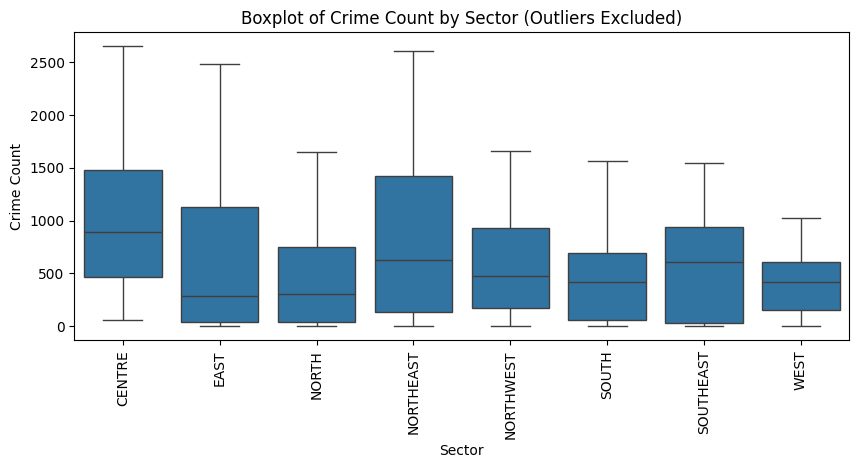

In [373]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4)) # Adjust the figure size as needed
sns.boxplot(x='Sector', y='Crime Count', data=df_agg, showfliers=False)
plt.xticks(rotation=90) # Rotate the sector names
plt.title('Boxplot of Crime Count by Sector (Outliers Excluded)')
plt.show()

Add a column called 'crime_pct' to showing the percentile of the crime count.

In [374]:
df_agg['crime_pct'] = df_agg['Crime Count'].rank(pct=True,method = 'min')

df_agg['crime_pct'].head()

0    0.821429
1    0.607143
2    0.844156
3    0.905844
4    0.201299
Name: crime_pct, dtype: float64

In [375]:
df_agg.sort_values('crime_pct',ascending=False).head(10)

,Sector,Community Name_cleaned,Crime Count,crime_pct
5,CENTRE,beltline,11188.0,1.000000
14,CENTRE,downtown commercial core,8028.0,0.996753
77,EAST,forest lawn,3611.0,0.993506
175,NORTHWEST,bowness,2942.0,0.990260
33,CENTRE,manchester industrial,2650.0,0.987013
140,NORTHEAST,marlborough,2603.0,0.983766
150,NORTHEAST,pineridge,2516.0,0.980519
162,NORTHEAST,sunridge,2498.0,0.977273
72,EAST,dover,2485.0,0.974026
13,CENTRE,crescent heights,2478.0,0.970779


<Axes: xlabel='crime_pct', ylabel='Crime Count'>

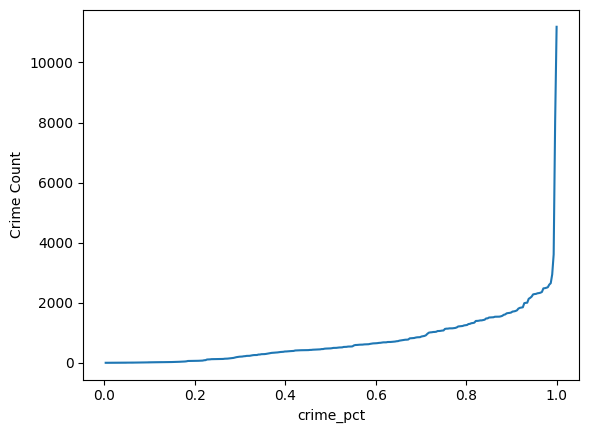

In [376]:
sns.lineplot(x = 'crime_pct', y = 'Crime Count', data = df_agg)

Update column names according to naming convention

In [379]:
df_agg.columns = df_agg.columns.str.lower().str.replace(' ', '_')

In [389]:
df_agg.rename(columns={'community_name_cleaned': 'community'},inplace=True)

Add a new column called 'id' as PRIMARY KEY.

In [391]:
df_agg['id'] = range(1, len(df_agg) + 1)

In [397]:
df_agg = df_agg.reindex(columns=['id', 'sector', 'community', 'crime_count', 'crime_pct'])

In [400]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           308 non-null    int64  
 1   sector       308 non-null    object 
 2   community    308 non-null    object 
 3   crime_count  308 non-null    float64
 4   crime_pct    308 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 12.2+ KB


# Loading into database

In [435]:

conn = sqlite3.connect('../database.db')

# Create a cursor
cursor = conn.cursor()



In [ ]:

'''
# Create a new table with an auto-incrementing id
cursor.execute("""
    CREATE TABLE crime (
        id INTEGER PRIMARY KEY,
        sector TEXT,
        community TEXT,
        crime_count REAL,
        crime_pct REAL
    )
""")

# Insert the data from the DataFrame into the table

df_agg.to_sql('crime', conn, if_exists='append', index=False)
'''

Check if the table is correct.

In [417]:
res = cursor.execute("SELECT * from crime")
res.fetchall()


[(1, 'CENTRE', 'altadore', 1394.0, 0.8214285714285714),
 (2, 'CENTRE', 'alyth/bonnybrook', 663.0, 0.6071428571428571),
 (3, 'CENTRE', 'banff trail', 1477.0, 0.8441558441558441),
 (4, 'CENTRE', 'bankview', 1713.0, 0.9058441558441559),
 (5, 'CENTRE', 'bel-aire', 65.0, 0.2012987012987013),
 (6, 'CENTRE', 'beltline', 11188.0, 1.0),
 (7, 'CENTRE', 'bridgeland/riverside', 2359.0, 0.9675324675324676),
 (8, 'CENTRE', 'britannia', 150.0, 0.2792207792207792),
 (9, 'CENTRE', 'burns industrial', 470.0, 0.487012987012987),
 (10, 'CENTRE', 'cambrian heights', 346.0, 0.38311688311688313),
 (11, 'CENTRE', 'capitol hill', 1534.0, 0.8636363636363636),
 (12, 'CENTRE', 'chinatown', 514.0, 0.525974025974026),
 (13, 'CENTRE', 'cliff bungalow', 1028.0, 0.7305194805194806),
 (14, 'CENTRE', 'crescent heights', 2478.0, 0.9707792207792207),
 (15, 'CENTRE', 'downtown commercial core', 8028.0, 0.9967532467532467),
 (16, 'CENTRE', 'downtown east village', 1997.0, 0.9318181818181818),
 (17, 'CENTRE', 'downtown west 

## Create a relationship table between rental_listings and crime.

In [427]:
def fuzzy_match(name,names_array):
    best_match = process.extractOne(name, names_array, score_cutoff=90)
    return best_match[0] if best_match else None

# Clean the community names in df_listings
df_listings['community_clean'] = df_listings['community'].str.lower().str.strip()

# Create an empty DataFrame for df_listing_with_crime
df_listing_with_crime = pd.DataFrame(columns=['id', 'listing_id', 'crime_id'])

# Initialize a list to collect new rows
new_rows = []

# Iterate through df_listings using itertuples for better performance
for listing in df_listings.itertuples():
    matched_community = fuzzy_match(listing.community_clean,df_agg['community'].unique())
    if matched_community:
        # Find the crime_id from df_agg where the community matches the fuzzy matched community
        crime_id = df_agg[df_agg['community'] == matched_community]['id'].iloc[0]
        # Append a new row to the list
        new_rows.append({'listing_id': listing.id, 'crime_id': crime_id})

# Create a DataFrame from the list of new rows
df_listing_with_crime = pd.DataFrame(new_rows)

# Create a new 'id' column that starts with 1 and increments for each row
df_listing_with_crime.insert(0, 'id', range(1, 1 + len(df_listing_with_crime)))

In [430]:
df_listing_with_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9188 entries, 0 to 9187
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          9188 non-null   int64
 1   listing_id  9188 non-null   int64
 2   crime_id    9188 non-null   int64
dtypes: int64(3)
memory usage: 215.5 KB


In [434]:
df_listing_with_crime.head(3)

,id,listing_id,crime_id
0,1,1613,213
1,2,2256,48
2,3,3744,184


Now create a new table for linking 'rental_listings' and 'crime'.

In [ ]:
'''cursor.execute("""
    CREATE TABLE IF NOT EXISTS listing_with_crime (
        id INTEGER PRIMARY KEY,
        listing_id INTEGER,
        crime_id INTEGER,
        FOREIGN KEY(listing_id) REFERENCES rental_listings (id)
        FOREIGN KEY(crime_id) REFERENCES crime(id)
        )
""")'''

In [436]:
df_listing_with_crime.to_sql('listing_with_crime', conn, if_exists='append', index=False)

9188

In [ ]:
conn.commit()

In [439]:
conn.close()